In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline

def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Refine bboxes

In [2]:
bboxes = pd.read_csv('predicted_bboxes.csv')
bboxes['coords'] = bboxes['coords'].apply(lambda x: np.fromstring(x[1:-1], sep=', ', dtype='int'))
bboxes.head()

,filename,coords
0,0000e88ab.jpg,"[160, 189, 433, 887]"
1,0001f9222.jpg,"[74, 4, 251, 752]"
2,00029d126.jpg,"[33, 33, 461, 1021]"
3,00050a15a.jpg,"[163, 26, 372, 1024]"
4,0005c1ef8.jpg,"[146, 11, 327, 1034]"


[173  56 485 990]
[ 126    9  531 1003]


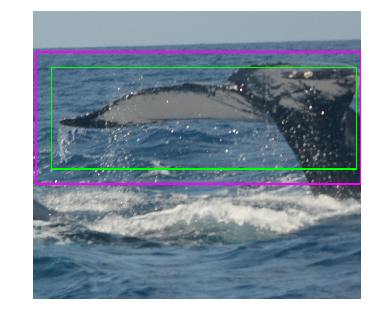

In [3]:
def refine_bbox(bbox, img, coeff_x=0.15, coeff_y=0.05):
    dist_x = (bbox[2] - bbox[0]) * coeff_x
    dist_y = (bbox[3] - bbox[1]) * coeff_y
    bbox_new = bbox.copy()
    bbox_new[0] = max(bbox[0]-dist_x, 0)
    bbox_new[1] = max(bbox[1]-dist_y, 0)
    bbox_new[2] = min(bbox[2]+dist_x, img.shape[0]-1)
    bbox_new[3] = min(bbox[3]+dist_y, img.shape[1]-1)
    return bbox_new

def read_img(img_name):
    path_train = '../humpback-whale-identification/data/train/'
    path_test = '../humpback-whale-identification/data/test/'
    img = cv2.imread(path_train + img_name)
    if img is None:
        img = cv2.imread(path_test + img_name)
    return img

img_name = '00d4a4967.jpg'
#img_name = '98ab97a0c.jpg'
img = read_img(img_name)
bbox = bboxes.loc[bboxes['filename'] == img_name].coords.values[0]

print(bbox)
bbox_new = refine_bbox(bbox, img)
print(bbox_new)

cv2.rectangle(img,(bbox[1], bbox[0]), (bbox[3], bbox[2]), (0,255,0), 3)
cv2.rectangle(img,(bbox_new[1], bbox_new[0]), (bbox_new[3], bbox_new[2]), (255,0,255), 3)

show(img)

In [45]:
#расширяем bboxы
#bboxes['coords'] = bboxes['coords'].apply(lambda bbox: refine_bbox(bbox))
bboxes['coords'] = [refine_bbox(bbox, read_img(img_name)) for
                    img_name, bbox in zip(bboxes['filename'], bboxes['coords'])]

#заменяем плохие
imgs_bad_bbox = ['b4cb30afd.jpg', '85a95e7a8.jpg', 'b370e1339.jpg', 'd4cb9d6e4.jpg', '6a72d84ca.jpg']
replaced_bboxes = [[540, 370, 600, 600], [430, 420, 470, 510], [560, 270, 660, 570], [350, 490, 380, 550], [470, 490, 500, 550]]
replaced_bboxes = list(map(lambda x: np.array(x, dtype=int), replaced_bboxes))
for replaced_bbox, img_bad_bbox in zip(replaced_bboxes, imgs_bad_bbox):
    bboxes.loc[bboxes['filename'] == img_bad_bbox, 'coords'] = [replaced_bbox]
    
bboxes.to_pickle("bboxes.pkl", protocol=2)

In [46]:
bboxes = pd.read_pickle("bboxes.pkl")
bboxes.head()

,filename,coords
0,0000e88ab.jpg,"[119, 154, 473, 921]"
1,0001f9222.jpg,"[47, 0, 277, 757]"
2,00029d126.jpg,"[0, 0, 496, 1049]"
3,00050a15a.jpg,"[131, 0, 403, 1049]"
4,0005c1ef8.jpg,"[118, 0, 354, 1049]"


# Check augmentation is good

Using TensorFlow backend.


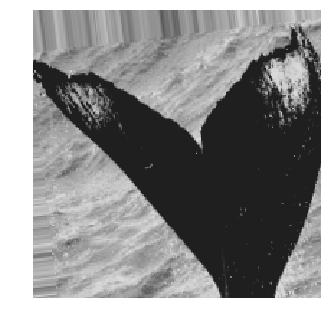

In [4]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    channel_shift_range=50)
    
bboxes = pd.read_pickle('bboxes.pkl').set_index('filename')
    
img_name = '000a6daec.jpg'
img_path = '../humpback-whale-identification/data/train/' + img_name
img = cv2.imread(img_path)
bbox = bboxes.loc[img_name][0]
img = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
img = cv2.resize(img, (200, 200))

x2 = aug.flow(np.expand_dims(img, axis=0), batch_size=1, shuffle=False)[0][0]

img = x2.astype('uint8').copy()

show(img)

In [5]:
bbox

array([   0,    0,  453, 1049])